In [1]:
!pip install torch torchvision mtcnn opencv-python matplotlib numpy
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [2]:
import torch
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from mtcnn import MTCNN

In [3]:
# Load the pre-trained GhostNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("ghostnet_100", pretrained=True, num_classes=512)  # 512-dimensional embeddings
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

GhostNet(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): GhostBottleneck(
        (ghost1): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (ghost2): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1)

In [4]:
# Initialize MTCNN for face detection
mtcnn = MTCNN()

# Define image preprocessing for GhostNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract GhostNet embeddings
def get_embedding(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()
    return embedding

In [5]:
faces_dir = "/content/faces/"  # Path to uploaded faces folder
uploaded_faces = {}
uploaded_embeddings = {}

for filename in os.listdir(faces_dir):
    img_path = os.path.join(faces_dir, filename)
    img = Image.open(img_path).convert("RGB")

    embedding = get_embedding(img)
    uploaded_faces[filename] = img
    uploaded_embeddings[filename] = embedding

In [6]:
group_img_path = "/content/DSCF3076.JPG"  # Path to the group image
group_img = Image.open(group_img_path).convert("RGB")

# Detect faces in the group image
group_img_cv = cv2.imread(group_img_path)
group_img_rgb = cv2.cvtColor(group_img_cv, cv2.COLOR_BGR2RGB)
faces = mtcnn.detect_faces(group_img_rgb)

group_boxes = []
group_embeddings = []

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    face_crop = group_img.crop((x, y, x+w, y+h))

    embedding = get_embedding(face_crop)

    group_boxes.append((x, y, w, h))
    group_embeddings.append(embedding)

In [10]:
from scipy.spatial.distance import cosine

threshold = 0.5  # Adjust this based on accuracy needs
face_matching_results = {}

for person, uploaded_emb in uploaded_embeddings.items():
    best_match = "Not Found"
    best_score = float("inf")

    for idx, group_emb in enumerate(group_embeddings):
        score = cosine(uploaded_emb, group_emb)
        if score < threshold and score < best_score:
            best_match = idx
            best_score = score

    face_matching_results[person] = best_match

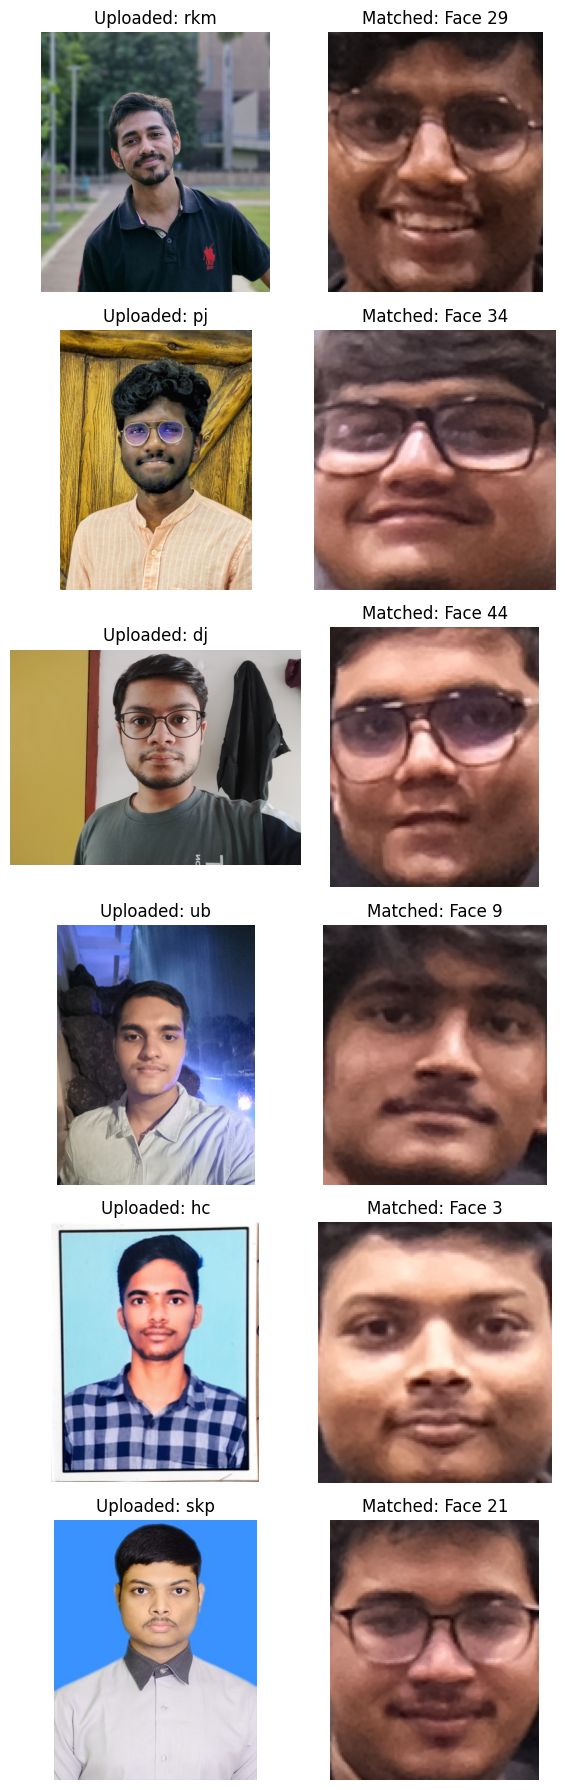

In [11]:
# Count matched faces
num_matches = sum(1 for v in face_matching_results.values() if v != "Not Found")

# Set up figure
fig, axes = plt.subplots(num_matches, 2, figsize=(6, num_matches * 3))
row_idx = 0

for person, matched_idx in face_matching_results.items():
    if matched_idx != "Not Found":  # Only plot matched faces
        # Load uploaded face
        uploaded_face_path = os.path.join(faces_dir, person)
        uploaded_face = Image.open(uploaded_face_path).convert("RGB")

        # Extract matched face from group image
        x, y, w, h = group_boxes[matched_idx]
        matched_face = group_img.crop((x, y, x + w, y + h))

        # Plot uploaded face
        axes[row_idx, 0].imshow(uploaded_face)
        axes[row_idx, 0].axis("off")
        axes[row_idx, 0].set_title(f"Uploaded: {person.split('.')[0]}")

        # Plot matched face from group image
        axes[row_idx, 1].imshow(matched_face)
        axes[row_idx, 1].axis("off")
        axes[row_idx, 1].set_title(f"Matched: Face {matched_idx + 1}")

        row_idx += 1  # Move to next row

plt.tight_layout()
plt.show()